# CNN MNIST Model - Train and Test

In [53]:
import tensorflow as tf
import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

### Load data

x_train is the dataset of 28x28 images of handwritten digits that the model will be trained on.

y_train is the dataset of labels that correspond to x_train.

x_test is the dataset of 28x28 images of handwritten digits that the model will be tested on.

y_test is the dataset of labels that correspond to x_test.

In [54]:
mnist = tf.keras.datasets.mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()

### Count by digit

In [55]:
unique, counts = np.unique(y_train, return_counts=True)
dict(zip(unique, counts))

{0: 5923,
 1: 6742,
 2: 5958,
 3: 6131,
 4: 5842,
 5: 5421,
 6: 5918,
 7: 6265,
 8: 5851,
 9: 5949}

### Normalization and Reshaping

##### The first convolution layer expects a single 60000x28x28x1 tensor instead of 60000 28x28x1 tensors.

In [56]:
# our image shape is 28X28
input_shape = (28, 28, 1)

# reshape train
x_train=x_train.reshape(x_train.shape[0], x_train.shape[1], x_train.shape[2], 1)
# reshape test
x_test = x_test.reshape(x_test.shape[0], x_test.shape[1], x_test.shape[2], 1)
# normalize values
x_train=x_train / 255.0
x_test=x_test/255.0

The labels for the training and the testing dataset are currently categorical and is not continuous. To include categorical dataset in our model, our labels should be converted to one-hot encodings.

For example, 2 becomes [0,0,1,0,0,0,0,0,0,0] and 7 becomes [0,0,0,0,0,0,0,1,0,0].

Run the following cell to transform the labels into one-hot encodings

In [57]:
y_train = tf.one_hot(y_train.astype(np.int32), depth=10)
y_test = tf.one_hot(y_test.astype(np.int32), depth=10)

### Now lets build out model

In [59]:
# model settings
batch_size = 64
num_classes = 10
epochs = 5

### Model structure description

- Conv2D layers are convolutions. Each filter (32 in the first two convolution layers and 64 in the next two convolution layers) transforms a part of the image (5x5 for the first two Conv2D layers and 3x3 for the next two Conv2D layers). The transformation is applied on the whole image.

- MaxPool2D is a downsampling filter. It reduces a 2x2 matrix of the image to a single pixel with the maximum value of the 2x2 matrix. The filter aims to conserve the main features of the image while reducing the size.

- Dropout is a regularization layer. In our model, 25% of the nodes in the layer are randomly ignores, allowing the network to learn different features. This prevents overfitting.

- relu is the rectifier, and it is used to find nonlinearity in the data. It works by returning the input value if the input value >= 0. If the input is negative, it returns 0.

- Flatten converts the tensors into a 1D vector.

- The Dense layers are an artificial neural network (ANN). The last layer returns the probability that an image is in each class (one for each digit).

As this model aims to categorize the images, we will use a categorical_crossentropy loss function.

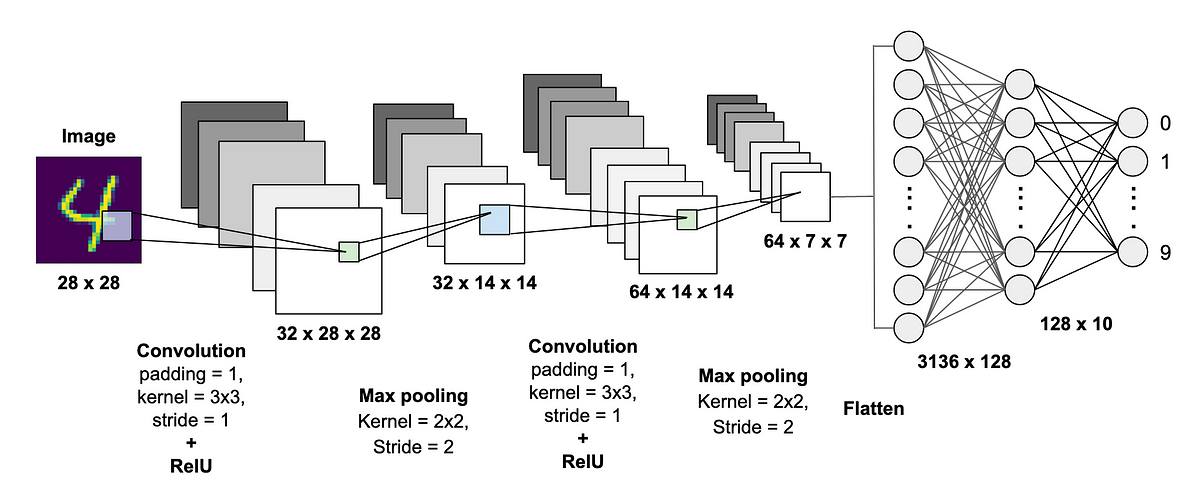

In [60]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (5,5), padding='same', activation='relu', input_shape=input_shape),
    tf.keras.layers.Conv2D(32, (5,5), padding='same', activation='relu'),
    tf.keras.layers.MaxPool2D(),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Conv2D(64, (3,3), padding='same', activation='relu'),
    tf.keras.layers.Conv2D(64, (3,3), padding='same', activation='relu'),
    tf.keras.layers.MaxPool2D(strides=(2,2)),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(num_classes, activation='softmax')
])

model.compile(optimizer=tf.keras.optimizers.RMSprop(epsilon=1e-08), loss='categorical_crossentropy', metrics=['acc'])

The following cell defines a CallBack so that if 99.5% accuracy is achieved, the model stops training. 

In [64]:
class maxAccuracyCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('acc')>0.995):
      print("\nReached 99.5% accuracy so cancelling training!")
      self.model.stop_training = True

callbacks = maxAccuracyCallback()

In [65]:
history = model.fit(x_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    validation_split=0.1,
                    callbacks=[callbacks])

Epoch 1/5
844/844 [==============================] - 15s 12ms/step - loss: 0.2072 - acc: 0.9356 - val_loss: 0.0484 - val_acc: 0.9863
Epoch 2/5
844/844 [==============================] - 10s 12ms/step - loss: 0.0748 - acc: 0.9789 - val_loss: 0.0354 - val_acc: 0.9902
Epoch 3/5
844/844 [==============================] - 10s 11ms/step - loss: 0.0583 - acc: 0.9826 - val_loss: 0.0424 - val_acc: 0.9888
Epoch 4/5
844/844 [==============================] - 10s 11ms/step - loss: 0.0513 - acc: 0.9859 - val_loss: 0.0291 - val_acc: 0.9920
Epoch 5/5
844/844 [==============================] - 10s 12ms/step - loss: 0.0489 - acc: 0.9866 - val_loss: 0.0288 - val_acc: 0.9922


#### evaluate the loss and accuracy of our model.

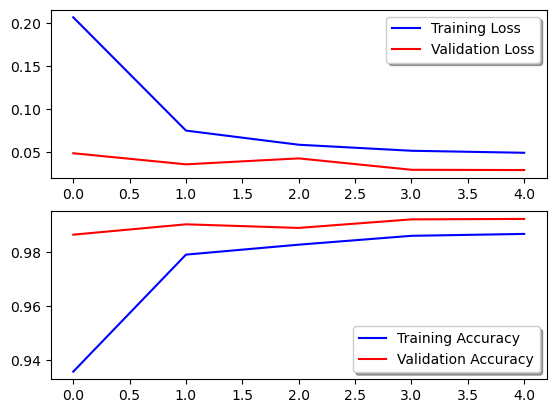

In [66]:
fig, ax = plt.subplots(2,1)
ax[0].plot(history.history['loss'], color='b', label="Training Loss")
ax[0].plot(history.history['val_loss'], color='r', label="Validation Loss",axes =ax[0])
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(history.history['acc'], color='b', label="Training Accuracy")
ax[1].plot(history.history['val_acc'], color='r',label="Validation Accuracy")
legend = ax[1].legend(loc='best', shadow=True)

#### Predict Results

In [67]:
test_loss, test_acc = model.evaluate(x_test, y_test)

313/313 [==============================] - 1s 3ms/step - loss: 0.0261 - acc: 0.9917


#### compute our confusion matrix using TensorFlow.

In [70]:
# Predict the values from the testing dataset
Y_pred = model.predict(x_test)
# Convert predictions classes to one hot vectors 
Y_pred_classes = np.argmax(Y_pred,axis = 1) 
# Convert testing observations to one hot vectors
Y_true = np.argmax(y_test,axis = 1)
# compute the confusion matrix
confusion_mtx = tf.math.confusion_matrix(Y_true, Y_pred_classes) 

### confusion matrix
This matrix shows label | prediction count. everything not in diagonal is miss-detection

<AxesSubplot: >

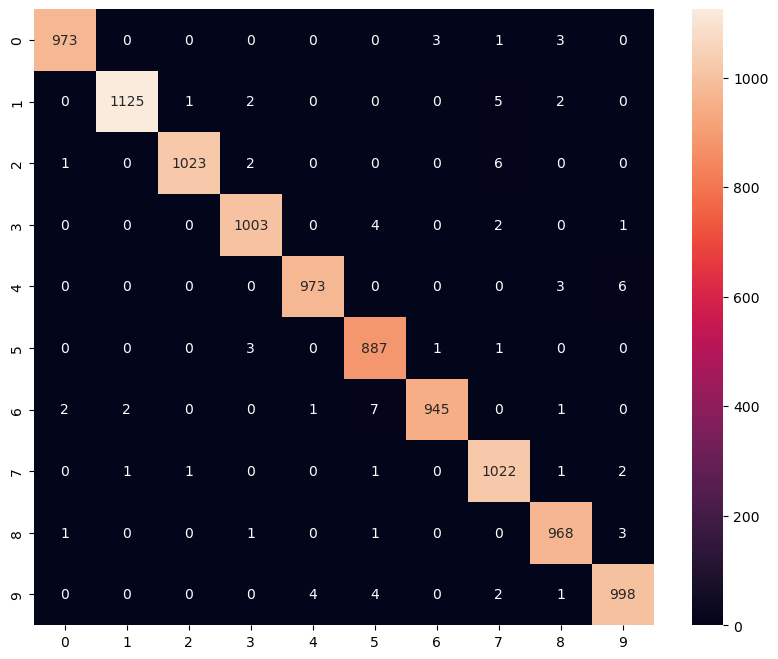

In [71]:
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mtx, annot=True, fmt='g')

# Model Summery

In [73]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 28, 28, 32)        832       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 28, 28, 32)        25632     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 14, 14, 64)        18496     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 14, 14, 64)        36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 7, 7, 64)          0

# Save the model

In [76]:
model.save('../model/digit_classifier_model')

INFO:tensorflow:Assets written to: ../model/digit_classifier_model\assets


# Load model (Test)

In [77]:
new_model = tf.keras.models.load_model('../model/digit_classifier_model')

# Check its architecture
new_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 28, 28, 32)        832       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 28, 28, 32)        25632     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 14, 14, 64)        18496     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 14, 14, 64)        36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 7, 7, 64)          0

In [81]:
# Evaluate the restored model
loss, acc = new_model.evaluate(x_test, y_test, verbose=2)
print('Restored model, accuracy: {:5.2f}%'.format(100 * acc))

print(new_model.predict(x_test).shape)

313/313 - 1s - loss: 0.0261 - acc: 0.9917
Restored model, accuracy: 99.17%
(10000, 10)
